# GUESS function
<p>version 0.1</p>
<p>Based on algorithm from thesis:</p>
<p><b>Bonifácio, Daniel A. B.</b> <i>Modelagem de sistema de detecção para mamografia por emissão de pósitrons utilizando detectores cintiadores monolíticos</i>, pg. 106, University of São Paulo, doctorate thesis, 2011.</p>
<p>Developed in iPython by Murata, H.</p>
<p>2021</p>

In [1]:
# Imports
import pandas as pd            # shift array and other stuff
import numpy as np             # linear algebra and other stuff
import glob                    # read files
import configparser as cp      # read config file
import math                    # maths (sqrt, pi, etc.)
import matplotlib.pyplot as plt# visualization

---
### Inputs:

In [2]:
# Data directory
dataDir = "../../../dados/aquisicoes/Testes_10Fev2021/colimador_1mm/central (16h)/"

# config.ini file input
fileConfig = "config.ini"

# Charge file name prefix
prefixCharge = "Charge_"

# Timing file name prefix
prefixTime = "Timetag_"

# From CAEN digitizer
nBoards   = 2
nChannels = 8        # per boards

---
### Configuration:

In [3]:
## Read config.ini file and get the variables
cfg = cp.RawConfigParser()
cfg.optionxform = str  # To preserve case in variable names
cfg.read(fileConfig)
par = dict(cfg.items('SIPM'))
for p in par:
    par[p]=par[p].split("#",1)[0].strip() # To get rid of inline comments
globals().update(par)  # Make them availible globally

print("Readout size:", readoutSize)

xSiPMs = int(xSiPMs)
print("Number of SiPMs in x-axis:", xSiPMs)

ySiPMs = int(ySiPMs)
print("Number of SiPMs in y-axis:", ySiPMs)

xPixelSize = int(xPixelSize)
print("SiPM pixel size in x-axis:", xPixelSize, "mm")

yPixelSize = int(yPixelSize)
print("SiPM pixel size in y-axis:", yPixelSize, "mm")

xSiPMCenter = xSiPMCenter.split()
for i in range(xSiPMs):
    xSiPMCenter[i] = float(xSiPMCenter[i])
print("Coordinates of each SiPM center in x-axis:", xSiPMCenter, "mm")

ySiPMCenter = ySiPMCenter.split()
for i in range(ySiPMs):
    ySiPMCenter[i] = float(ySiPMCenter[i])
print("Coordinates of each SiPM center in y-axis:", ySiPMCenter, "mm")

# print(par)

Readout size: FRONT
Number of SiPMs in x-axis: 8
Number of SiPMs in y-axis: 8
SiPM pixel size in x-axis: 6 mm
SiPM pixel size in y-axis: 6 mm
Coordinates of each SiPM center in x-axis: [-12.6, -9.0, -5.4, -1.8, 1.8, 5.4, 9.0, 12.6] mm
Coordinates of each SiPM center in y-axis: [-12.6, -9.0, -5.4, -1.8, 1.8, 5.4, 9.0, 12.6] mm


---
### Some calculations:

In [4]:
# Pitches calculation in x and y-axis
xPitch = 7.2
yPitch = 7.2
X = np.zeros(xSiPMs, dtype=np.float)
sX = xPixelSize / 3
for i in range(xSiPMs):
    X[i] = ((i * xPitch) - (xSiPMs * xPitch / 2)) + (xPitch / 2)
    
Y = np.zeros(ySiPMs, dtype=np.float)
sY = yPixelSize / 3
for i in range(ySiPMs):
    Y[i] = ((i * yPitch) - (ySiPMs * yPitch / 2)) + (yPitch / 2)
    

---
### Some informations:

In [5]:
# Print some informations
print("Critical angle (Crystal/Optical coupling) is  ", math.pi * math.sin(float(refIndexOptC)/float(refIndexCrys)))
print("Critical angle (Crystal/Intermediate layer) is", math.pi * math.sin(float(refIndexIntL)/float(refIndexCrys)))
print("Critical angle (Crystal/MAPD-3N Epoxy) is     ", math.pi * math.sin(float(refIndexProt)/float(refIndexCrys)))

Critical angle (Crystal/Optical coupling) is   2.3928850869301543
Critical angle (Crystal/Intermediate layer) is 2.3928850869301543
Critical angle (Crystal/MAPD-3N Epoxy) is      2.3224413952584806


---
### Read charge and time data from CAEN digitizer

<p><b>CAEN Charge values are stored in:</b> vecCharge[b, c]</p>
<p><b>CAEN Time values are stored in: </b>  vecTime[b, c]</p>
<p>b: boards, c: channels</p>

In [6]:
# Read data files to get the size (number of lines) normalizing to the file with the fewest lines 

nCAENEvents = 0
for nB in range(nBoards):
#     print(" Board: {b}".format(b = nB))
    for nC in range(nChannels):               
        chargeFileName = dataDir + prefixCharge + str(nB) + "_" + str(nC) + ".txt"
        num_lines = sum(1 for line in open(chargeFileName))
#         print(" Channel: {c} - Nb of events: {d}".format(c = nC, d = num_lines)) 
        
        # prevents different number of lines (events) between channels an chooses the channel with the lowest 
        if ((nB == 0) and (nC == 0)):
            nCAENEvents = num_lines
        elif num_lines < nCAENEvents:
                nCAENEvents = num_lines

# Number of data cut to the minimum value between all files
# print("Number of events to use: {nl}".format(nl = nCAENEvents))

# Read data and put the Time Tag in matrices
# Using the extended Time (second column) 
vecTime = np.zeros((nBoards, nChannels, nCAENEvents), dtype=np.double)
overflTime = 2**32-1;  #4294967295
for nB in range(nBoards):
    for nC in range(nChannels):               
        timeFileName = dataDir + prefixTime + str(nB) + "_" + str(nC) + ".txt"
        a, b = np.genfromtxt(timeFileName, unpack=True)
        for line in range(nCAENEvents):
            vecTime[nB, nC, line] = a[line] + b[line] * overflTime
            
# Read data and put the charge in matrices
vecCharge= np.zeros((nBoards, nChannels, nCAENEvents), dtype=np.double)
for nB in range(nBoards):
    for nC in range(nChannels):               
        chargeFileName = dataDir + prefixCharge + str(nB) + "_" + str(nC) + ".txt"
        a = np.genfromtxt(chargeFileName, unpack=True)
        for line in range(nCAENEvents):
            vecCharge[nB, nC, line] = a[line]


print('Total charge and time data:', nCAENEvents, 'events.')   
print('CAEN events variable are stored in nCAENEvents.')

Total charge and time data: 50432 events.
CAEN events variable are stored in nCAENEvents.


---
### Align charge and time data

<p><b>Aligned Charge values:</b> shVecCharge[b, c]</p>
<p><b>Aligned Time values:</b> shVecTime[b, c]</p>
<p>b: boards, c: channels</p>

In [7]:
## Using the differences between Time Tags of channel 1, we find the first aligned line of each board
## Two values of the time difference between three subsequent lines will be used as condition to
## assign the lines as aligned in time

# print("Alignment of events starting...")
maxTimeDiff   = math.sqrt(2) * 50 # maximum time difference for events in the same Trigger Time Tag
linesToSearch = 150               # maximum line to alignment match
refChan = 0 # reference channel    
refLine = 0 # reference line
matchLine = 0 # match line

# fill time differences in vectors [b x c x l]
td = np.zeros((nBoards, nChannels, linesToSearch), dtype=np.int) 
for nB in range(nBoards):
    for nC in range(nChannels):
        for nL in range(linesToSearch):
            td[nB, nC, nL] = vecTime[nB, nC, nL + 1] - vecTime[nB, nC, nL]


# take one time difference value and compares to all data
def searchAlignment(s):    
    for nB in range(nBoards):    
        for nC in range(nChannels):        
            for nL in range(linesToSearch):
                # return results in an array of True or False
                td_array = np.isclose(td[nB, nC, nL], td, atol = maxTimeDiff)                  
                result = np.where(td_array == True)   
                b = result[0] # Boards
                c = result[1] # Channels
                l = result[2] # Events

                # Is necessary an alignment match with all data 
                if (len(result[0]) == nBoards * nChannels):                                
                    for i in range(len(result[0])):
                        s[b[i], c[i]] = l[i]  
                    return

# shift lines for each board and channels:
shift = np.ones((nBoards, nChannels), dtype=np.int) 
shift = shift * (-1) 
searchAlignment(shift)

if(np.max(shift) > linesToSearch - 1):
    print('No alignment found. Maybe is necessary to modify linesToSearch or increase maxTimeDiff variable.')    
else:
    print('Alignment found in ', np.max(shift), ' line(s) at least.')


def shiftEvents(a, idB, idC, shiftleft):
    if (shiftleft > 0):
        a[idB, idC, :] = np.roll(a[idB, idC, :], shiftleft * (-1))
        a[idB, idC, shiftleft * (-1):] = 0
    return a

tmp_vecTime = np.copy(vecTime)
tmp_vecCharge = np.copy(vecCharge)


for nB in range(nBoards):
    for nC in range(nChannels):        
        shVecTime = shiftEvents(tmp_vecTime, nB, nC, shift[nB, nC])
        shVecCharge = shiftEvents(tmp_vecCharge, nB, nC, shift[nB, nC])

cutArray = np.max(shift) * (-1)

shVecTime = shVecTime[:, :, :cutArray]
shVecCharge = shVecCharge[:, :, :cutArray]

nEvents = len(shVecTime[0,0])
print('Total aligned charge and time data:', len(shVecTime[0,0]), ' events.')
print('Aligned events variable are stored in nEvents.')

Alignment found in  1  line(s) at least.
Total aligned charge and time data: 50431  events.
Aligned events variable are stored in nEvents.


---
### Overflow correction for aligned charge and time data

<p><b>Aligned and overflow corrected Charge values:</b> matCharge[b, c]</p>
<p><b>Aligned and overflow corrected Time values:</b> matTime[b, c]</p>
<p>b: boards, c: channels</p>

In [8]:
# Mount a new matrices with the aligned time tags and charge values
# overflow value 32767 will be set to 0
matTime = np.copy(shVecTime)
matCharge = np.copy(shVecCharge)

matCharge[matCharge > 32700] = 0

---
### Background removal
<p>The initial value of the parameter which represents the <i>background</i> radiation ($Nph_{BG}$)
is defined as the simple average of the two signals ($Nph_{low1}$ and $Nph_{low2}$)
of the lowest intensity collected by the sum in a row or column by the SiPM matrix:</p> <br>
$$ Nph_{BG} = \frac{Nph_{low1} + Nph_{low2}}{2}$$
<p>Where event data for $n$ channels is defined by:</p> <br>
$$ Nph = [Nph_0, Nph_1, ... , Nph_{n - 1}]$$ <br>
<p>The background $Nph_{BG}$ is removed from all event data and negative data is 0 ($Nph_{cond(i)} \Rightarrow Nph_i - Nph_{BG} > 0$, $i$ = channel number). The new event data is $Nph_{NoBG}$</p> <br>
$$ Nph_{NoBG} = [(Nph_{cond(0)} \rightarrow  (Nph_0 - Nph_{BG}))\wedge(\neg Nph_{cond(0)} \rightarrow  0), (Nph_{cond(1)} \rightarrow  (Nph_1 - Nph_{BG}))\wedge(\neg Nph_{cond(1)} \rightarrow  0), ... , (Nph_{cond(n-1)} \rightarrow  (Nph_{n-1} - Nph_{BG}))\wedge(\neg Nph_{cond(n-1)} \rightarrow  0)]$$

In [9]:
def background(data, b, c_inf, c_sup, event):        
    """
    Parameters
    ----------
    data   : Multi-dimensional array (float)
             data[b, c, e] where:
                b = board
                c = channel
                e = event
    b      : Number of the board related to an axis. 
             A range of channels between c_inf and c_sup of the board 'b' belong the X/Y-Axis.
    c_inf  : inferior channel of the channels range from board 'b' belong the X/Y-Axis.
    c_sup  : superior channel of the channels range from board 'b' belong the X/Y-Axis.
    events : Total number of events.
    """     
    Nphlow1 = sorted(data[b, range(c_inf, c_sup + 1, 1), event], reverse = True)[-1]
    Nphlow2 = sorted(data[b, range(c_inf, c_sup + 1, 1), event], reverse = True)[-2]    
    NphBG = (Nphlow1 + Nphlow2) / 2    
    NphNoBG = data[b, range(c_inf, c_sup + 1, 1), event] - NphBG
    NphNoBG[NphNoBG < 0] = 0
#     print(data[b, range(c_inf, c_sup + 1, 1), event])
#     print(Nphlow1)
#     print(Nphlow2)
#     print(NphBG)
#     print(NphNoBG)
    return NphNoBG

---
### Zero outliers removal
<p>Data that deviate from the trend of distribution of the collected signals. </p>
<p>The algorithm to zero outliers removal is:</p>
<ol>
    <li>$$i_{max} = \{ i \in \mathbb{N}_{[n]} | arg \, max_{i}(Nph) \},[n]=\{0, 1, ..., n -1\} $$</li><br>
    <li>$$\forall i \in \{i_{max},  n - 1\} (Nph_{i} = 0 \rightarrow Nph_{i + 1} = 0), i < n - 1$$</li><br>
    <li>$$\forall i \in \{i_{max}, 0\} (Nph_{i} = 0 \rightarrow Nph_{i - 1} = 0), i > 0$$</li>
</ol>


In [10]:
def zeroOutliers(data):        
    """
    Parameters
    ----------
    data   : event data array (float).
    """       
    iMax = np.where(data == sorted(data, reverse = False)[-1])
    iZeros = np.where(data == 0)    
    
    NphZO = np.copy(data)
    if (iZeros[0][0] < iMax[0][0]):
        NphZO[:iZeros[0][0]] = 0
    else:
        NphZO[iZeros[0][0]:] = 0 
#     print(data)
#     print(NphZO[:iMax[0][0]] )
#     print(NphZO[iMax[0][0]:] )
    return NphZO

---
### Outliers removal
<p>Data that deviate from the trend of distribution of the collected signals. </p>
<p>The algorithm to outliers removal is:</p>
<ol>
    <li>$$i_{max} = \{ i \in \mathbb{N}_{[n]} | arg \, max_{i}(Nph) \},[n]=\{0, 1, ..., n -1\} $$</li><br>
    <li>$$\forall i \in \{i_{max},  n - 1\} (Nph_{i} > Nph_{i+1} \rightarrow Nph_i = 0), i < n - 1$$</li><br>
    <li>$$\forall i \in \{i_{max}, 0\} (Nph_{i} > Nph_{i+1} \rightarrow Nph_{i - 1} = 0), i > 0$$</li>
</ol>

In [11]:
def outliers(data):
    """
    Parameters
    ----------
    data   : event data array (float).
    """  
    iMax = np.where(data == sorted(data, reverse = False)[-1])           
    NphO = np.copy(data)
    
    leftSide = NphO[:iMax[0][0]]
    rightSide = NphO[iMax[0][0]:]
    
    if (sorted(leftSide, reverse = False) != leftSide.tolist()):
        iMin = np.where(NphO == sorted(leftSide, reverse = True)[-1])
        NphO[:iMin[0][0]] = 0 
    
    if (sorted(rightSide, reverse = True) != rightSide.tolist()):
        iMin = np.where(NphO == sorted(rightSide, reverse = True)[-1])
        NphO[iMin[0][0]:] = 0         
                
   
    return NphO

---
### Weighted average of signals 
<ol>
    <li> $$ \overline{u} = \frac{\sum{(Nph_i - 0.4Nph_{i_{max}})}u_i}{\sum{(Nph_i - 0.4Nph_{i_{max}})}}$$
        where:    
    $$i_{max} = \{ i \in \mathbb{N}_{[n]} | arg \, max_{i}(Nph) \},[n]=\{0, 1, ..., n -1\} $$</li><br>
    <li> $$ Nph_{term} = Nph_i - 0.4Nph_{i_{max}}$$ </li><br>
    <li>$$\forall i \in \{0,  n - 1\} (Nph_{term} < 0 \rightarrow Nph_{term} = 0)$$</li><br>
    <li>$$\forall i \in \{i_{max},  n - 1\} (Nph_{i} <  Nph_{i - 1} \rightarrow \overline{u}), i < n - 1$$</li><br>
    <li>$$\forall i \in \{i_{max}, 0\} (Nph_{i} < Nph_{i + 1} \rightarrow \overline{u}), i > 0$$</li>
</ol>

In [12]:
 def average(data, c_inf, c_sup, axis): 
    """
    Parameters
    ----------
    data   : event data array (float).
    c_inf  : inferior channel of the channels range from board 'b' belong the X/Y-Axis.
    c_sup  : superior channel of the channels range from board 'b' belong the X/Y-Axis.
    axis   : X/Y-Axis with pitches
    """      
    fach = 0.4    
    NphSup = 0.;    
    NphInf = 0.;
    NphSupTerm = 0.;
    iMax = np.where(data == sorted(data, reverse = False)[-1])    
    Nph = np.copy(data)  
    
    for i in range(c_inf, c_sup + 1, 1):        
        NphSupTerm = Nph[i] - fach * Nph[iMax[0][0]]
        if (NphSupTerm < 0):
            NphSupTerm = 0
        NphSup = NphSup + axis[iMax[0][0]] * NphSupTerm
        NphInf = NphInf + NphSupTerm
    NphInf = 1
    NphAvg = NphSup / NphInf       
    return NphAvg

---
### Guess function:

In [13]:
# Guess function
#def guess(n, Max, Min, Y, Nph, sNph):
def guess(data, b, c_inf, c_sup, event, axis):
    
    # Background calculation (NphBG)
    NphNoBG = background(data, b, c_inf, c_sup, event)    
    
    # Outliers removal (can be used Zero Outliers Removal)
    NphO = outliers(NphNoBG)
    
    # average
    NphAvg = average(NphO, c_inf, c_sup, axis)    

    return NphAvg

---
### Get X/Y data from Guess method:

<p>Populates data set with x and y values</p>

In [14]:
# Choose the number of events:
# for only CAEN digitizer events use nCAENEvents
# for aligned or aligned with overflow correction use nEvents
events = nEvents
#events = nCAENEvents

xValues = np.zeros(events, dtype=np.float)
yValues = np.zeros(events, dtype=np.float)

# Choose the charge data:
# for only CAEN digitizer charge data use vecCharge
# for aligned charge data use shVecCharge
# for aligned and overflow correction charge data use matCharge
chargeData = matCharge
#chargeData = vecCharge
#chargeData = shVecCharge

for i in range(events):
    xValues[i] = guess(chargeData, 0, 0, 7, i, X)
    yValues[i] = guess(chargeData, 1, 0, 7, i, Y)

---
### Data visualization:
<p>Dispersion:</p>

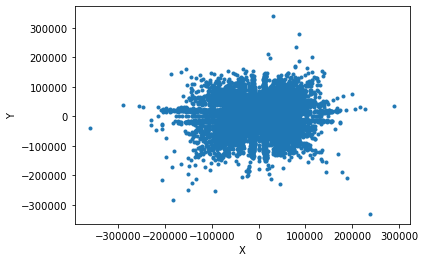

In [15]:
mPixel = 4
imgChannels = mPixel * nChannels
vecPixels = np.linspace(((-1) * imgChannels / 2 + 1),(imgChannels / 2 - 1), imgChannels - 1)

plt.plot(xValues, yValues, '.')
# plt.xlim(min(vecPixels), max(vecPixels))
# plt.ylim(min(vecPixels), max(vecPixels))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

<p>Comparison with <b>Center of Mass</b> algorithm:</p>

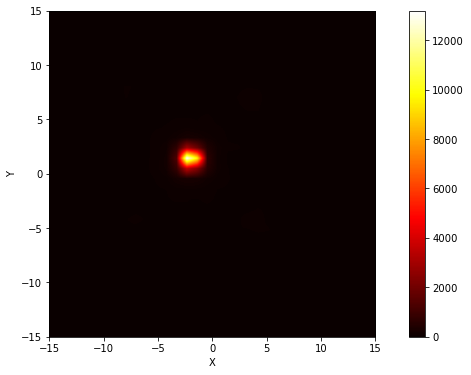

In [16]:
mPixel = 4
imgChannels = mPixel * nChannels
vecPixels = np.linspace(((-1) * imgChannels / 2 + 1),(imgChannels / 2 - 1), imgChannels - 1)
Image = np.zeros((imgChannels, imgChannels), dtype = np.int)
meanRow = 0
meanColumn = 0

for nL in range(events):      
    sumCol = np.sum(chargeData[0, range(nChannels), nL])    
    if (sumCol > 0):
        sumRow = np.sum(chargeData[1, range(nChannels), nL])        
        if (sumRow > 0):
            meanColumn = int(np.round(mPixel * np.sum(chargeData[0, range(nChannels), nL] * range(nChannels)) / sumCol))            
            meanRow = int(np.round(mPixel * np.sum(chargeData[1, range(nChannels), nL] * range(nChannels)) / sumRow))            
    if ((meanColumn > 0 and meanColumn < imgChannels + 1) and (meanRow > 0 and meanRow < imgChannels + 1)):
        Image[meanRow, meanColumn] = Image[meanRow, meanColumn] + 1

plt.figure(figsize=(12, 6))
plt.imshow(Image, cmap= 'hot', interpolation = 'bilinear', extent=[min(vecPixels), max(vecPixels), min(vecPixels), max(vecPixels)]) 
plt.colorbar() 
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


---
### End of GUESS Method